#### Análisis y Procesamiento de Señales

# Tarea Semanal N°8
## *Filtrado digital lineal de ECG*

#### Augusto Colugnatti

## Introducción teórica
---

## Desarrollo

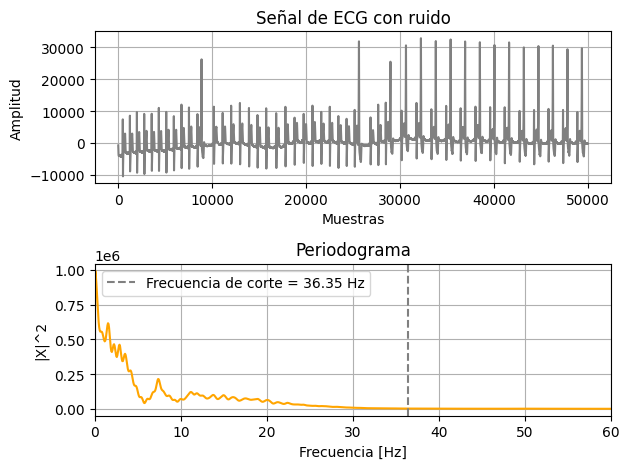

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from numpy.fft import fft
import scipy.signal as sp
import scipy.signal.windows as window
import scipy.stats as st
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

# ------------------------------- Señal de ECG con ruido ------------------------------- #

fs_ECG = 1000

# ECG = sio.whosmat ('./ECG_TP4.mat') # devuelve una lista de variables dentro del archivo .mat (MATLAB)
mat_struct = sio.loadmat ('./ECG_TP4.mat')
# print("Variables encontradas en el archivo .mat:", mat_struct.keys()) # esto muestra las variables dentro del archivo .mat (lo miro desde el explorador de variables)

ecg_one_lead = mat_struct ['ecg_lead'].ravel() # ECG con ruido

hb_1 = mat_struct['heartbeat_pattern1']
hb_2 = mat_struct['heartbeat_pattern2']

ECG_cr = ecg_one_lead[0:50000].ravel()

N_ECG_cr = len (ECG_cr)

df_ECG_cr = fs_ECG / N_ECG_cr
nn_ECG_cr = np.arange (N_ECG_cr)

promedios_ECG_cr = 16
nperseg_ECG_cr = N_ECG_cr // promedios_ECG_cr

ff_ECG_cr, per_ECG_cr = sp.welch (ECG_cr, nfft = 5*nperseg_ECG_cr, fs = fs_ECG, nperseg = nperseg_ECG_cr, window = 'flattop')

energia_acum_cr = np.cumsum (per_ECG_cr)
energia_acum_cr_norm = energia_acum_cr / energia_acum_cr[-1]
corte_ECG_cr = energia_acum_cr_norm[-1] * 0.995
indice_corte_cr = int (np.where (energia_acum_cr_norm >= corte_ECG_cr)[0][0])
frec_corte_cr = ff_ECG_cr[indice_corte_cr]

plt.figure (3)

plt.subplot (2, 1, 1)
plt.plot (nn_ECG_cr, ECG_cr, color='gray')
# plt.plot (ff_ECG_cr, 10*np.log10(np.abs(per_ECG_cr))) # representación en dB
plt.title ("Señal de ECG con ruido")
plt.ylabel ("Amplitud")
plt.xlabel ("Muestras")
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_ECG_cr, per_ECG_cr, color='orange')
plt.axvline (frec_corte_cr, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_cr:.2f} Hz')
plt.title ("Periodograma")
plt.ylabel ("|X|^2")
plt.xlabel ("Frecuencia [Hz]")
plt.grid (True)
plt.legend ()
plt.xlim (0, 60)

plt.tight_layout()
plt.show()

Los parámetros para el diseño de la plantilla surgen de analizar cuáles son las frecuencias que se deben atenuar (aquellas generadas por ruido, o que simplemente no me interesan) y cuáles no. Es decir, quiero un filtro con la mayor atenuación posible en banda de rechazo, y que resulte inocuo en banda de paso. Para identificar dichas frecuencias, debe observarse la envolvente de la señal para determinar las regiones afectadas por baja y alta frecuencia. Como punto de partida, se buscan las oscilaciones más "lentas" de linea de base para dar con las bajas frecuencias, mientras que para las altas frecuencias, puedo eliminar fácilmente aquellas que se encuentren por encima de la frecuencia de corte al estimar el ancho de banda de la señal.

In [4]:
# --------------------------------------------------- Diseño de plantilla --------------------------------------------------- #

fs = fs_ECG

wp = [0.8, 35] # frecuencia de corte/paso (rad/seg)
ws = [0.1, 40] # frecuencia de stop/detenida (rad/seg)

ripple = 1
atte = 40

# plot_plantilla(filter_type = 'bandpass', fpass = wp, ripple = ripple, fstop = ws, attenuation = atte, fs = fs)

In [5]:
# ------------------------------------------------ 1° filtro FIR (Ventanas) ------------------------------------------------ #

frecs_1 = [0, 0.1, 0.8, 35, 40, fs//2] # firwin2 me pide que empiece en 0 y termine en fs/2
ganancia_deseada_1 = [0, 0, 1, 1, 0, 0]
# con esto doy los puntos que va a tratar de interpolar el filtro
cant_coef_1 = 2000
retardo_1 = (cant_coef_1 - 1) // 2

fir_win_rect = sig.firwin2 (numtaps = cant_coef_1, freq = frecs_1, gain = ganancia_deseada_1, window = 'boxcar', fs = fs, nfreqs = int((np.ceil(np.sqrt(cant_coef_1*2)**2))-1))
w_4, h_4 = sig.freqz (b = fir_win_rect, worN=np.logspace(-2, 2, 1000), fs = fs)

ecg_filt_4 = sig.lfilter (b = fir_win_rect, a = 1, x = ecg_one_lead)

# -------------------------------------------- 2° filtro FIR (Cuadrados mínimos) -------------------------------------------- #

frecs_2 = [0, 0.4, 0.8, 35, 35.4, fs/2] # acá se "predistorsionó la plantilla" para dar más holgura a las verdaderas
                                        # frecuencias de la plantilla (alternativa para no aumentar coeficientes)
ganancia_deseada_2 = [0, 0, 1, 1, 0, 0]
peso = [2, 1, 12] # acá tuve que "pesar", darle más importancia, a la transición de baja porque no cumplía con la plantilla
cant_coef_2 = 2501 # firls me pide una cantidad par, pues solo diseña filtros de tipo I
retardo_2 = (cant_coef_2 - 1) // 2

fir_ls = sig.firls (numtaps = cant_coef_2, bands = frecs_2, desired = ganancia_deseada_2, weight = peso, fs = fs)
w_5, h_5 = sig.freqz (b = fir_ls, worN=np.logspace(-2, 2, 2000), fs = fs)

ecg_filt_5 = sig.lfilter (b = fir_ls, a = 1, x = ecg_one_lead)

# -------------------------------------------- 3° filtro FIR (Parks - McClellan) -------------------------------------------- #

frecs_3 = [0, 0.1, 0.8, 35, 35.7, fs/2] # para este método debo hacer "simétricas" las transiciones, sino no converge
ganancia_deseada_3 = [0, 1, 0] # Peaks-McClellan toma la ganancia de a sectores

cant_coef_3 = 1500
retardo_3 = (cant_coef_3 - 1) // 2

fir_pm = sig.remez (numtaps = cant_coef_3, bands = frecs_3, desired = ganancia_deseada_3, fs = fs)
w_6, h_6 = sig.freqz (b = fir_pm, worN=np.logspace(-2, 2, 2500), fs = fs)

ecg_filt_6 = sig.lfilter (b = fir_pm, a = 1, x = ecg_one_lead)

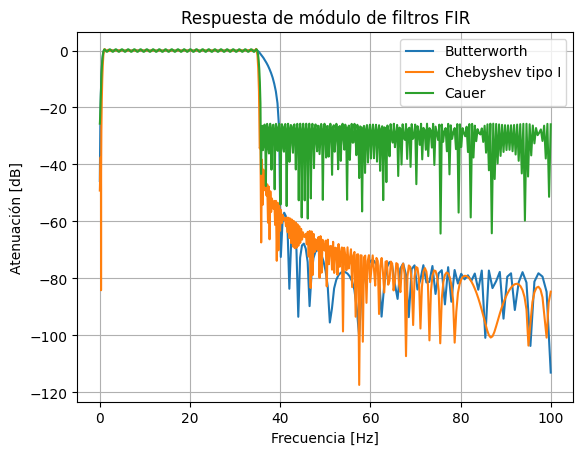

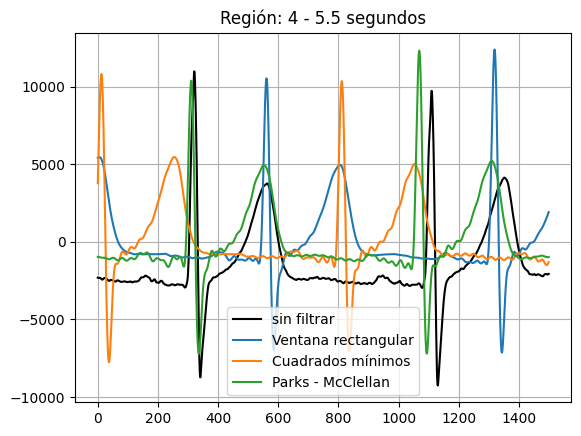

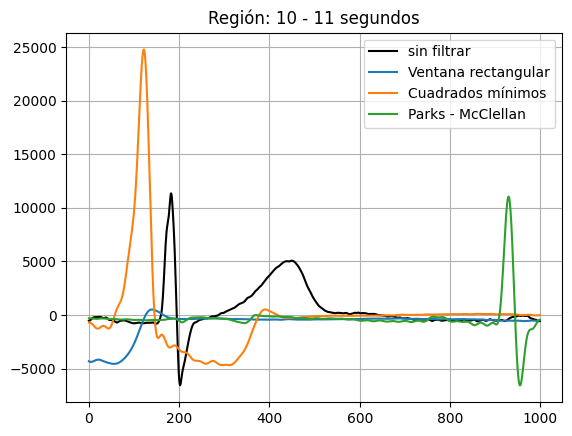

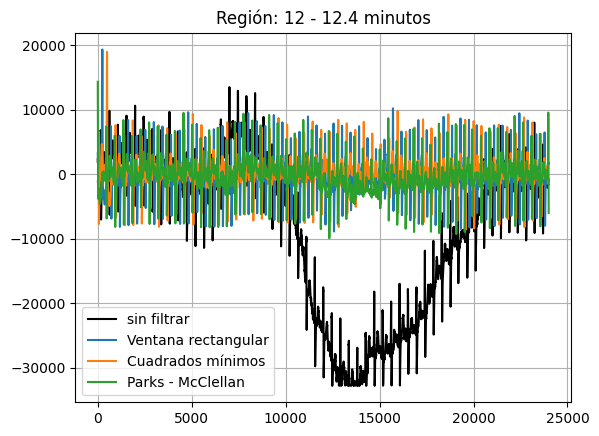

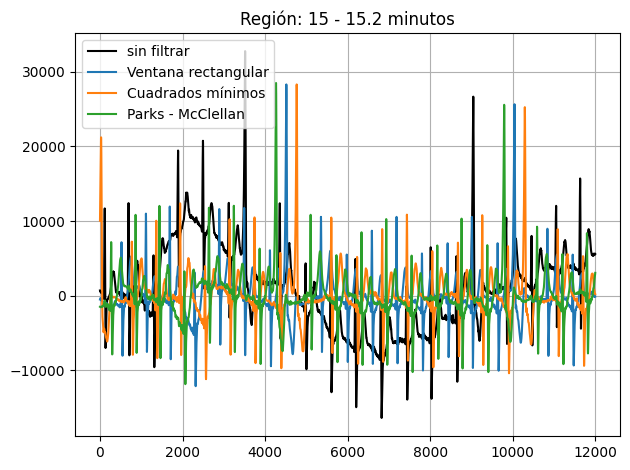

In [6]:
# ------------------------------------------------ Comparación de filtros FIR ------------------------------------------------ #

plt.figure ()

plt.plot (w_4, 20*np.log10(np.abs(h_4)), label='Butterworth')
plt.plot (w_5, 20*np.log10(np.abs(h_5)), label='Chebyshev tipo I')
plt.plot (w_6, 20*np.log10(np.abs(h_6)), label='Cauer')
plt.title ('Respuesta de módulo de filtros FIR')
plt.xlabel ('Frecuencia [Hz]')
plt.ylabel ('Atenuación [dB]')
plt.legend ()
plt.grid (True)

plt.figure ()

plt.plot (ecg_one_lead[4000:5500], label='sin filtrar', color='black')
plt.plot (ecg_filt_4[4000:5500], label='Ventana rectangular')
plt.plot (ecg_filt_5[4000:5500], label='Cuadrados mínimos')
plt.plot (ecg_filt_6[4000:5500], label='Parks - McClellan')
plt.title ('Región: 4 - 5.5 segundos')
plt.grid (True)
plt.legend ()

plt.figure ()

plt.plot (ecg_one_lead[10000:11000], label='sin filtrar', color='black')
plt.plot (ecg_filt_4[10000:11000], label='Ventana rectangular')
plt.plot (ecg_filt_5[10000:11000], label='Cuadrados mínimos')
plt.plot (ecg_filt_6[10000:11000], label='Parks - McClellan')
plt.title ('Región: 10 - 11 segundos')
plt.grid (True)
plt.legend ()

plt.figure ()

plt.plot (ecg_one_lead[720000:744000], label='sin filtrar', color='black')
plt.plot (ecg_filt_4[720000:744000], label='Ventana rectangular')
plt.plot (ecg_filt_5[720000:744000], label='Cuadrados mínimos')
plt.plot (ecg_filt_6[720000:744000], label='Parks - McClellan')
plt.title ('Región: 12 - 12.4 minutos')
plt.grid (True)
plt.legend ()

plt.figure ()

plt.plot (ecg_one_lead[900000:912000], label='sin filtrar', color='black')
plt.plot (ecg_filt_4[900000:912000], label='Ventana rectangular')
plt.plot (ecg_filt_5[900000:912000], label='Cuadrados mínimos')
plt.plot (ecg_filt_6[900000:912000], label='Parks - McClellan')
plt.title ('Región: 15 - 15.2 minutos')
plt.grid (True)
plt.legend ()

plt.tight_layout ()
plt.show ()

In [7]:
# ------------------------------------------------ 1° filtro FIR (Ventanas) ------------------------------------------------ #

frecs_1 = [0, 0.1, 0.8, 35, 40, fs//2] # firwin2 me pide que empiece en 0 y termine en fs/2
ganancia_deseada_1 = [0, 0, 1, 1, 0, 0]
# con esto doy los puntos que va a tratar de interpolar el filtro
cant_coef_1 = 2000
retardo_1 = (cant_coef_1 - 1) // 2

fir_win_rect = sig.firwin2 (numtaps = cant_coef_1, freq = frecs_1, gain = ganancia_deseada_1, window = 'boxcar', fs = fs, nfreqs = int((np.ceil(np.sqrt(cant_coef_1*2)**2))-1))
w_4, h_4 = sig.freqz (b = fir_win_rect, worN=np.logspace(-2, 2, 1000), fs = fs)

ecg_filt_4 = sig.lfilter (b = fir_win_rect, a = 1, x = ecg_one_lead)

# -------------------------------------------- 2° filtro FIR (Cuadrados mínimos) -------------------------------------------- #

frecs_2 = [0, 0.4, 0.8, 35, 35.4, fs/2] # acá se "predistorsionó la plantilla" para dar más holgura a las verdaderas
                                        # frecuencias de la plantilla (alternativa para no aumentar coeficientes)
ganancia_deseada_2 = [0, 0, 1, 1, 0, 0]
peso = [2, 1, 12] # acá tuve que "pesar", darle más importancia, a la transición de baja porque no cumplía con la plantilla
cant_coef_2 = 2501 # firls me pide una cantidad par, pues solo diseña filtros de tipo I
retardo_2 = (cant_coef_2 - 1) // 2

fir_ls = sig.firls (numtaps = cant_coef_2, bands = frecs_2, desired = ganancia_deseada_2, weight = peso, fs = fs)
w_5, h_5 = sig.freqz (b = fir_ls, worN=np.logspace(-2, 2, 2000), fs = fs)

ecg_filt_5 = sig.lfilter (b = fir_ls, a = 1, x = ecg_one_lead)

# -------------------------------------------- 3° filtro FIR (Parks - McClellan) -------------------------------------------- #

frecs_3 = [0, 0.1, 0.8, 35, 35.7, fs/2] # para este método debo hacer "simétricas" las transiciones, sino no converge
ganancia_deseada_3 = [0, 1, 0] # Peaks-McClellan toma la ganancia de a sectores

cant_coef_3 = 1500
retardo_3 = (cant_coef_3 - 1) // 2

fir_pm = sig.remez (numtaps = cant_coef_3, bands = frecs_3, desired = ganancia_deseada_3, fs = fs)
w_6, h_6 = sig.freqz (b = fir_pm, worN=np.logspace(-2, 2, 2500), fs = fs)

ecg_filt_6 = sig.lfilter (b = fir_pm, a = 1, x = ecg_one_lead)

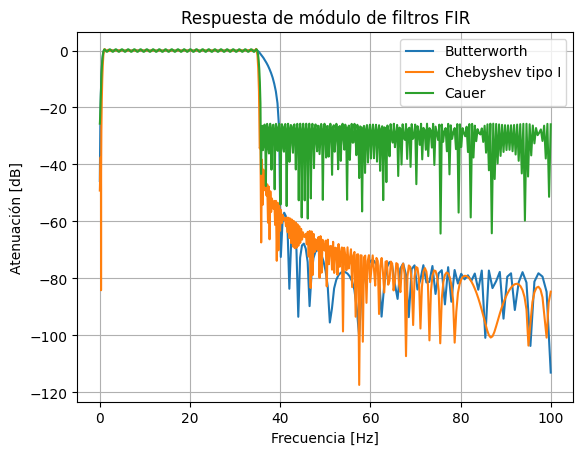

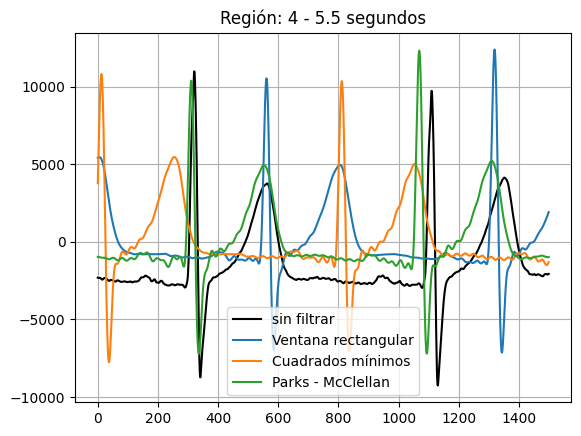

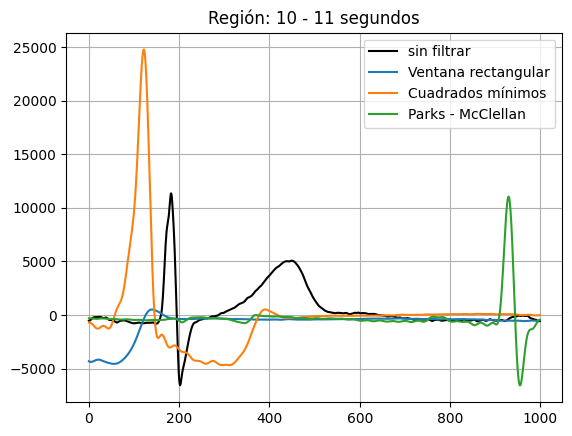

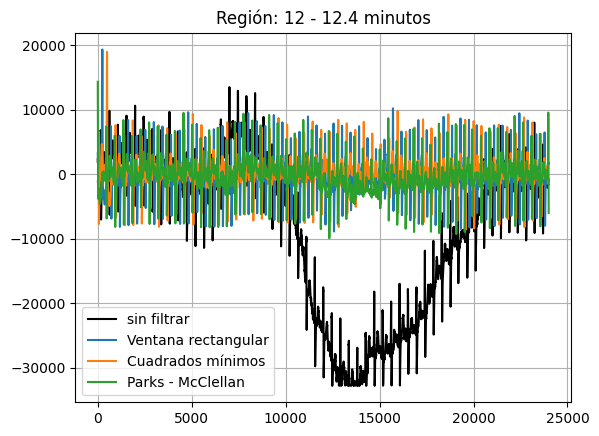

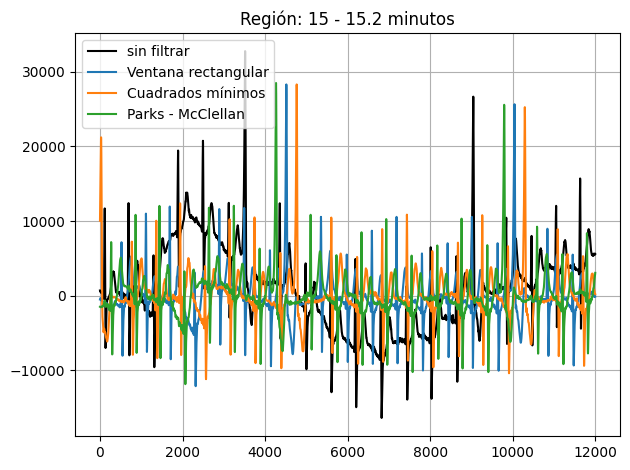

In [8]:
# ------------------------------------------------ Comparación de filtros FIR ------------------------------------------------ #

plt.figure ()

plt.plot (w_4, 20*np.log10(np.abs(h_4)), label='Butterworth')
plt.plot (w_5, 20*np.log10(np.abs(h_5)), label='Chebyshev tipo I')
plt.plot (w_6, 20*np.log10(np.abs(h_6)), label='Cauer')
plt.title ('Respuesta de módulo de filtros FIR')
plt.xlabel ('Frecuencia [Hz]')
plt.ylabel ('Atenuación [dB]')
plt.legend ()
plt.grid (True)

plt.figure ()

plt.plot (ecg_one_lead[4000:5500], label='sin filtrar', color='black')
plt.plot (ecg_filt_4[4000:5500], label='Ventana rectangular')
plt.plot (ecg_filt_5[4000:5500], label='Cuadrados mínimos')
plt.plot (ecg_filt_6[4000:5500], label='Parks - McClellan')
plt.title ('Región: 4 - 5.5 segundos')
plt.grid (True)
plt.legend ()

plt.figure ()

plt.plot (ecg_one_lead[10000:11000], label='sin filtrar', color='black')
plt.plot (ecg_filt_4[10000:11000], label='Ventana rectangular')
plt.plot (ecg_filt_5[10000:11000], label='Cuadrados mínimos')
plt.plot (ecg_filt_6[10000:11000], label='Parks - McClellan')
plt.title ('Región: 10 - 11 segundos')
plt.grid (True)
plt.legend ()

plt.figure ()

plt.plot (ecg_one_lead[720000:744000], label='sin filtrar', color='black')
plt.plot (ecg_filt_4[720000:744000], label='Ventana rectangular')
plt.plot (ecg_filt_5[720000:744000], label='Cuadrados mínimos')
plt.plot (ecg_filt_6[720000:744000], label='Parks - McClellan')
plt.title ('Región: 12 - 12.4 minutos')
plt.grid (True)
plt.legend ()

plt.figure ()

plt.plot (ecg_one_lead[900000:912000], label='sin filtrar', color='black')
plt.plot (ecg_filt_4[900000:912000], label='Ventana rectangular')
plt.plot (ecg_filt_5[900000:912000], label='Cuadrados mínimos')
plt.plot (ecg_filt_6[900000:912000], label='Parks - McClellan')
plt.title ('Región: 15 - 15.2 minutos')
plt.grid (True)
plt.legend ()

plt.tight_layout ()
plt.show ()

## Conclusiones